<a href="https://colab.research.google.com/github/shivansh2310/Finance-Stuff/blob/main/Long_Short_reversal_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [28]:
# Downloading data from Yahoo Finance
tickers = ["^NSEI", "HDFCBANK.NS", "RELIANCE.NS", "TCS.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INFY.NS", "KOTAKBANK.NS", "BAJAJFINSV.NS", "BAJFINANCE.NS", "HDFC.NS", "AXISBANK.NS", "ITC.NS", "SBIN.NS", "BHARTIARTL.NS", "MARUTI.NS", "ASIANPAINT.NS", "LT.NS", "NESTLEIND.NS", "SUNPHARMA.NS"]
data = yf.download(tickers, start="2022-01-01", end="2023-01-01")["Adj Close"]

[*********************100%***********************]  20 of 20 completed


In [60]:

# Calculating weekly returns
weekly_returns = data.resample("W-FRI").last().pct_change().dropna()

# Define the holding period for the long-short strategy
holding_period = 4 # weeks

# Create a new DataFrame for the long-short portfolio
portfolio = pd.DataFrame(index=weekly_returns.index[holding_period:], columns=['long', 'short'])



In [61]:
# Loop over the weeks and calculate the long-short portfolio returns
for i in range(holding_period, len(weekly_returns)):
    # Calculate the mean return and standard deviation over the holding period
    mean_return = weekly_returns.iloc[i-holding_period:i].mean()
    std_dev = weekly_returns.iloc[i-holding_period:i].std()
    
    # Sort the stocks by their returns over the holding period
    sorted_returns = mean_return.sort_values()
    
    # Take the top and bottom stocks to be long and short, respectively
    long_stock = sorted_returns.index[-1]
    short_stock = sorted_returns.index[0]
    
    # Calculate the weights for the long and short positions
    long_weight = 0.5 + 0.5 * ((weekly_returns[long_stock].iloc[i] - mean_return[long_stock]) / std_dev[long_stock])
    short_weight = 0.5 - 0.5 * ((weekly_returns[short_stock].iloc[i] - mean_return[short_stock]) / std_dev[short_stock])
    
    # Add the long and short positions to the portfolio DataFrame
    portfolio.loc[weekly_returns.index[i], 'long'] = long_weight
    portfolio.loc[weekly_returns.index[i], 'short'] = short_weight
    
# Calculate the weekly portfolio returns by multiplying the weights with the individual stock returns
portfolio_returns = (portfolio['long'] * weekly_returns.iloc[holding_period:, :-1].sum(axis=1)) \
                    - (portfolio['short'] * weekly_returns.iloc[holding_period:, :-1].sum(axis=1))


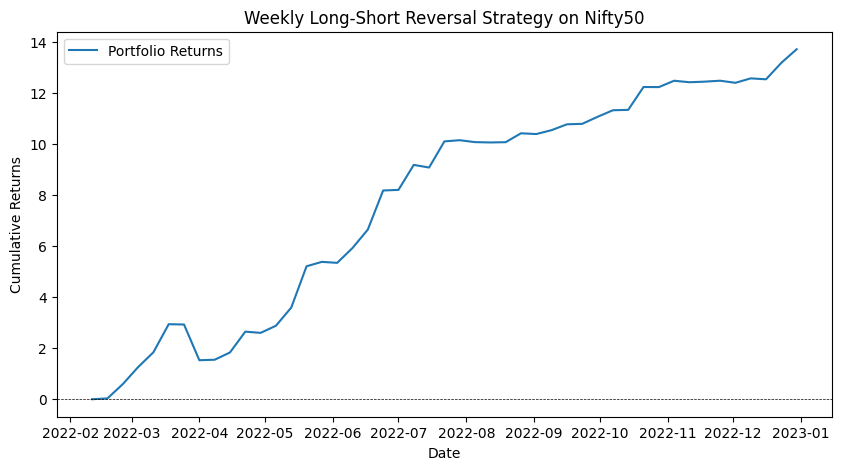

In [62]:

# Plotting the portfolio returns
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(portfolio_returns.cumsum(), label="Portfolio Returns")
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.5)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")
ax.set_title("Weekly Long-Short Reversal Strategy on Nifty50")
plt.show()

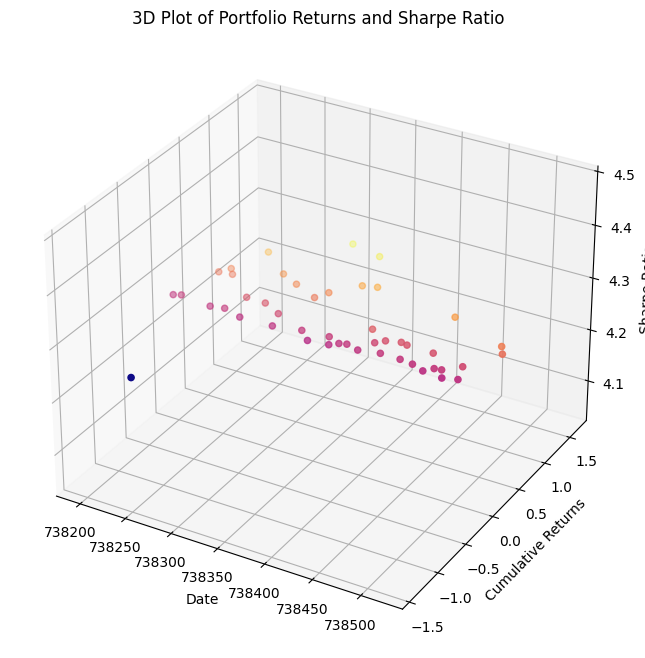

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sharpe_ratio = np.sqrt(52) * np.mean(portfolio_returns) / np.std(portfolio_returns)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Convert datetime objects to numerical values
x = [date.toordinal() for date in portfolio_returns.index]
y = portfolio_returns.values
z = sharpe_ratio

ax.scatter(x, y, z, c=portfolio_returns, cmap='plasma')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('3D Plot of Portfolio Returns and Sharpe Ratio')
plt.show()

